In [1]:
import os
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cpu



### Some smaple datas

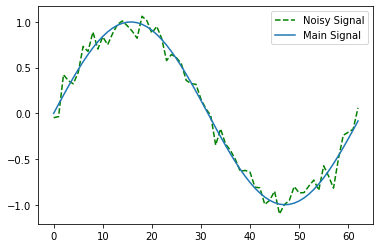

In [3]:
time_interval = np.arange(0,2*np.pi,0.1)
sin_wave = np.sin(time_interval)
noise = np.random.normal(0,0.1,len(time_interval))
plt.plot(noise+sin_wave,'--g',label='Noisy Signal')
plt.plot(sin_wave,label='Main Signal')
plt.legend()

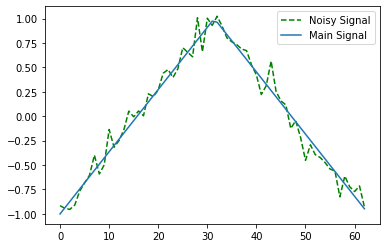

In [4]:
triangle_wave = signal.sawtooth(time_interval, 0.5)
noise = np.random.normal(0,0.1,len(time_interval))
plt.plot(noise+triangle_wave,'--g',label='Noisy Signal')
plt.plot(triangle_wave,label='Main Signal')
plt.legend()

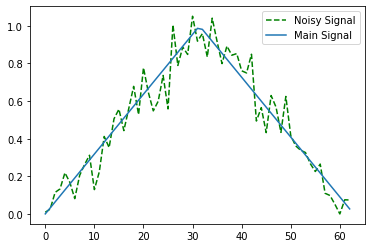

In [5]:
saw_wave = (signal.sawtooth(time_interval, 0.5)+1)/2
noise = np.random.normal(0,0.1,len(time_interval))
plt.plot(noise+saw_wave,'--g',label='Noisy Signal')
plt.plot(saw_wave,label='Main Signal')
plt.legend()

### Making Datas

In [6]:
class WavesDataset(Dataset):
    def __init__(self, num_datas, variance):
        
        self.num_datas = num_datas
        self.noisy_datas = []
        self.real_datas = []
        time_interval = np.arange(0,2*np.pi,0.1)
        for i in range(self.num_datas):
            
            noise = np.random.normal(0,variance,len(time_interval))
            data0 = saw_wave+noise
            data1 = triangle_wave+noise
            data2 = sin_wave+noise

            self.noisy_datas.append(data0)
            self.real_datas.append(saw_wave)
            self.noisy_datas.append(data1)
            self.real_datas.append(triangle_wave)
            self.noisy_datas.append(data2)
            self.real_datas.append(sin_wave)
        

    def __len__(self):
        return self.num_datas

    def __getitem__(self, index):
        noisy = self.noisy_datas[index]
        real = self.real_datas[index]

        return torch.tensor(noisy), torch.tensor(real)

In [7]:
def get_loader(num_datas=1000, batch_size=32, shuffle=True, pin_memory=True, num_workers=0, variance=0.1):
  
    dataset_train = WavesDataset(num_datas, variance)
    dataset_test =  WavesDataset(int(num_datas/10), variance)

    train_loader = DataLoader(
        dataset=dataset_train,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory
    )

    test_loader = DataLoader(
        dataset=dataset_test,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory
    )

    return train_loader, test_loader

### RNN Network

In [8]:
class DenoiserRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DenoiserRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

#### Training

In [8]:
def validation():
  
  Loss = 0
  with torch.no_grad():
    for idx, (noisy_data, main_data) in enumerate(test_loader):
        input2net = noisy_data.unsqueeze(2).float() 
        expected_out = main_data.unsqueeze(2).float()
        outputs = Net(input2net)
        loss = criterion(outputs, expected_out)
        Loss = Loss+loss.item()
  Loss = Loss/(idx+1)
  return Loss

In [9]:
def train(print_every):
    loss_valid = []
    loss_train = []

    num_itters = len(train_loader)
    for epoch in range(num_epochs):
        step = 0
        for idx, (noisy_data, main_data) in enumerate(train_loader):
            input2net = noisy_data.unsqueeze(2).float() 
            expected_out = main_data.unsqueeze(2).float()
            outputs = Net(input2net)
            loss = criterion(outputs, expected_out)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if step % print_every == 0:
                loss_val = validation()
                stats = '{2}/{3} - {0}/{1} |  Loss train - val = {4:.4f} - {5:.4f}'.format(
                        idx, num_itters, epoch, num_epochs, loss.item(), loss_val)
                print('\r' + stats)
                loss_valid.append(loss_val)
                loss_train.append(loss.item())
            step+=1
    return loss_valid, loss_train

0/5 - 0/1563 |  Loss train - val = 0.4507 - 0.4546
0/5 - 100/1563 |  Loss train - val = 0.0623 - 0.0676
0/5 - 200/1563 |  Loss train - val = 0.0223 - 0.0216
0/5 - 300/1563 |  Loss train - val = 0.0169 - 0.0179
0/5 - 400/1563 |  Loss train - val = 0.0167 - 0.0160
0/5 - 500/1563 |  Loss train - val = 0.0143 - 0.0147
0/5 - 600/1563 |  Loss train - val = 0.0127 - 0.0137
0/5 - 700/1563 |  Loss train - val = 0.0142 - 0.0128
0/5 - 800/1563 |  Loss train - val = 0.0123 - 0.0121
0/5 - 900/1563 |  Loss train - val = 0.0120 - 0.0115
0/5 - 1000/1563 |  Loss train - val = 0.0108 - 0.0110
0/5 - 1100/1563 |  Loss train - val = 0.0101 - 0.0105
0/5 - 1200/1563 |  Loss train - val = 0.0112 - 0.0101
0/5 - 1300/1563 |  Loss train - val = 0.0092 - 0.0097
0/5 - 1400/1563 |  Loss train - val = 0.0091 - 0.0093
0/5 - 1500/1563 |  Loss train - val = 0.0097 - 0.0087
1/5 - 0/1563 |  Loss train - val = 0.0080 - 0.0084
1/5 - 100/1563 |  Loss train - val = 0.0076 - 0.0078
1/5 - 200/1563 |  Loss train - val = 0.0059 

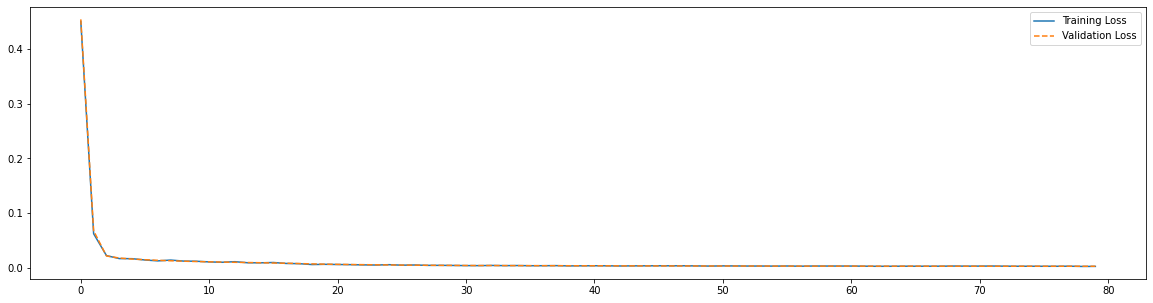

In [33]:
num_epochs = 5
input_dim = 1
hidden_size = 30
num_layers = 1
lr = 3e-4

Net = DenoiserRNN(input_dim, hidden_size, 1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(Net.parameters(),lr=lr)

train_loader, test_loader = get_loader(50000)
loss_val, loss_train = train(100)

fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, '--',label='Validation Loss')
plt.legend()
plt.show()

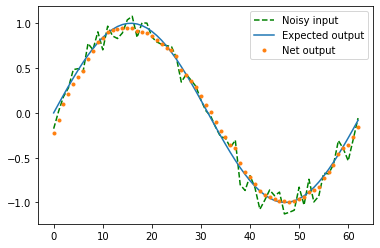

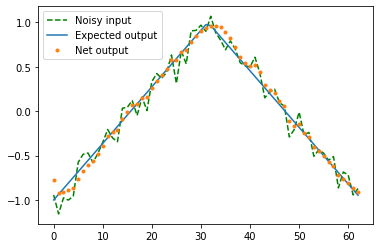

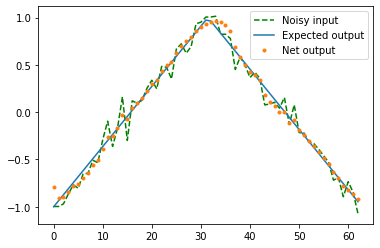

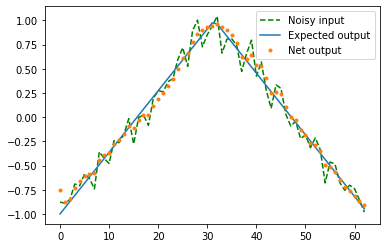

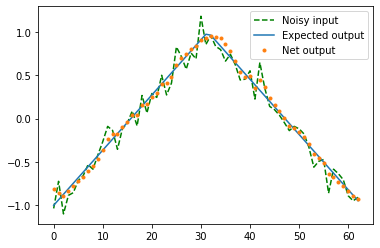

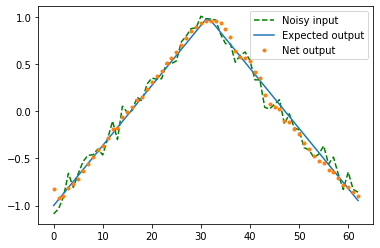

In [27]:
for idx, (noisy_data, main_data) in enumerate(test_loader):
    input2net = noisy_data.unsqueeze(2).float() 
    expected_out = main_data.unsqueeze(2).float()
    with torch.no_grad():
        output = Net(input2net)
    plt.plot(input2net[0,:,0].numpy(),'--g',label='Noisy input')
    plt.plot(expected_out[0,:,0].numpy(),label='Expected output')
    plt.plot(output[0,:,0].numpy(),'.',label='Net output')
    plt.legend()
    plt.show()
    if idx>4:
        break


### LSTM Network

In [10]:
class DenoiserLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DenoiserLSTM, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

#### Training

In [29]:
def validation():
  
  Loss = 0
  with torch.no_grad():
    for idx, (noisy_data, main_data) in enumerate(test_loader):
        input2net = noisy_data.unsqueeze(2).float() 
        expected_out = main_data.unsqueeze(2).float()
        outputs = Net(input2net)
        loss = criterion(outputs, expected_out)
        Loss = Loss+loss.item()
  Loss = Loss/(idx+1)
  return Loss

In [30]:
def train(print_every):
    loss_valid = []
    loss_train = []

    num_itters = len(train_loader)
    for epoch in range(num_epochs):
        step = 0
        for idx, (noisy_data, main_data) in enumerate(train_loader):
            input2net = noisy_data.unsqueeze(2).float() 
            expected_out = main_data.unsqueeze(2).float()
            outputs = Net(input2net)
            loss = criterion(outputs, expected_out)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if step % print_every == 0:
                loss_val = validation()
                stats = '{2}/{3} - {0}/{1} |  Loss train - val = {4:.4f} - {5:.4f}'.format(
                        idx, num_itters, epoch, num_epochs, loss.item(), loss_val)
                print('\r' + stats)
                loss_valid.append(loss_val)
                loss_train.append(loss.item())
            step+=1
    return loss_valid, loss_train

0/2 - 0/1563 |  Loss train - val = 0.3402 - 0.3487
0/2 - 100/1563 |  Loss train - val = 0.2179 - 0.1931
0/2 - 200/1563 |  Loss train - val = 0.0467 - 0.0427
0/2 - 300/1563 |  Loss train - val = 0.0214 - 0.0213
0/2 - 400/1563 |  Loss train - val = 0.0222 - 0.0161
0/2 - 500/1563 |  Loss train - val = 0.0189 - 0.0135
0/2 - 600/1563 |  Loss train - val = 0.0141 - 0.0120
0/2 - 700/1563 |  Loss train - val = 0.0109 - 0.0110
0/2 - 800/1563 |  Loss train - val = 0.0110 - 0.0100
0/2 - 900/1563 |  Loss train - val = 0.0107 - 0.0092
0/2 - 1000/1563 |  Loss train - val = 0.0063 - 0.0085
0/2 - 1100/1563 |  Loss train - val = 0.0075 - 0.0079
0/2 - 1200/1563 |  Loss train - val = 0.0090 - 0.0075
0/2 - 1300/1563 |  Loss train - val = 0.0055 - 0.0070
0/2 - 1400/1563 |  Loss train - val = 0.0053 - 0.0065
0/2 - 1500/1563 |  Loss train - val = 0.0067 - 0.0062
1/2 - 0/1563 |  Loss train - val = 0.0072 - 0.0060
1/2 - 100/1563 |  Loss train - val = 0.0048 - 0.0059
1/2 - 200/1563 |  Loss train - val = 0.0064 

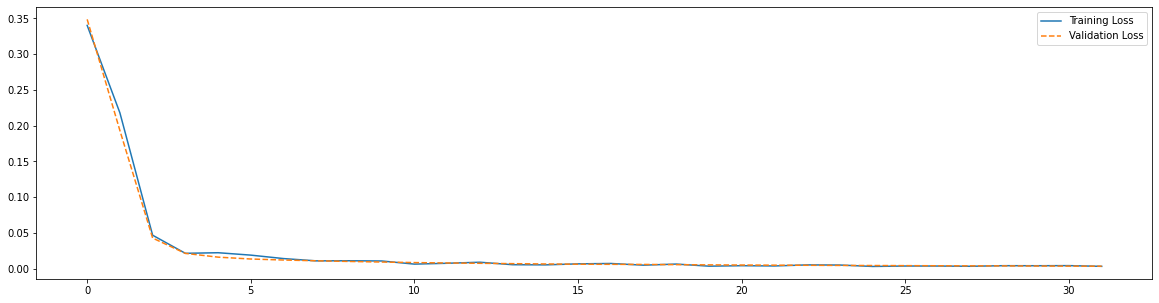

In [44]:
num_epochs = 2
input_dim = 1
hidden_size = 30
num_layers = 1
lr = 3e-4

Net = DenoiserLSTM(input_dim, hidden_size, 1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(Net.parameters(),lr=lr)

train_loader, test_loader = get_loader(50000,variance=0.1)
loss_val, loss_train = train(100)

fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, '--',label='Validation Loss')
plt.legend()
plt.show()

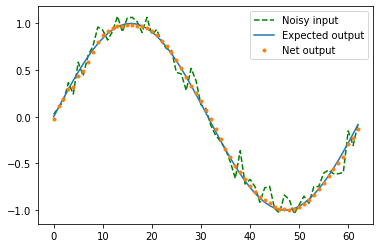

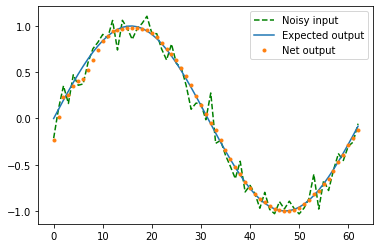

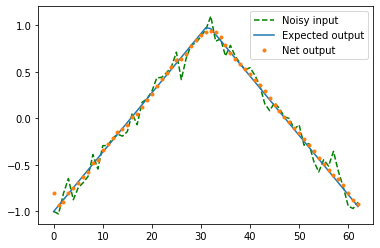

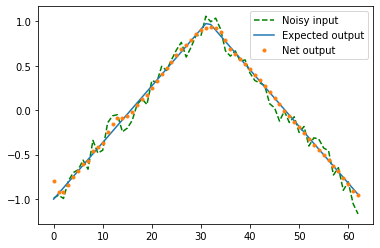

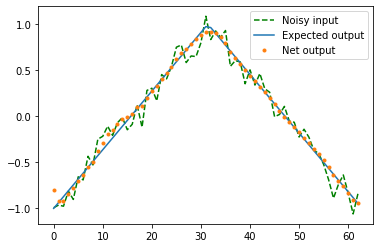

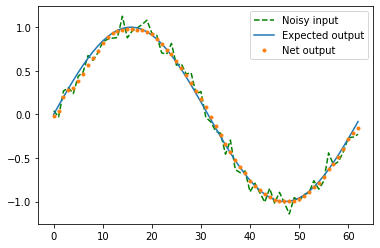

In [32]:
for idx, (noisy_data, main_data) in enumerate(test_loader):
    input2net = noisy_data.unsqueeze(2).float() 
    expected_out = main_data.unsqueeze(2).float()
    with torch.no_grad():
        output = Net(input2net)
    plt.plot(input2net[0,:,0].numpy(),'--g',label='Noisy input')
    plt.plot(expected_out[0,:,0].numpy(),label='Expected output')
    plt.plot(output[0,:,0].numpy(),'.',label='Net output')
    plt.legend()
    plt.show()
    if idx>4:
        break

### NonStationary noise

In [45]:
class WavesDataset(Dataset):
    def __init__(self, num_datas, variance):
        
        self.num_datas = num_datas
        self.noisy_datas = []
        self.real_datas = []
        time_interval = np.arange(0,2*np.pi,0.1)
        for i in range(self.num_datas):
            
            noise = np.random.rand(len(time_interval))
            data0 = saw_wave+noise
            data1 = triangle_wave+noise
            data2 = sin_wave+noise

            self.noisy_datas.append(data0)
            self.real_datas.append(saw_wave)
            self.noisy_datas.append(data1)
            self.real_datas.append(triangle_wave)
            self.noisy_datas.append(data2)
            self.real_datas.append(sin_wave)
        

    def __len__(self):
        return self.num_datas

    def __getitem__(self, index):
        noisy = self.noisy_datas[index]
        real = self.real_datas[index]

        return torch.tensor(noisy), torch.tensor(real)

0/2 - 0/1563 |  Loss train - val = 0.4983 - 0.4906
0/2 - 100/1563 |  Loss train - val = 0.2409 - 0.2206
0/2 - 200/1563 |  Loss train - val = 0.0946 - 0.1062
0/2 - 300/1563 |  Loss train - val = 0.0357 - 0.0392
0/2 - 400/1563 |  Loss train - val = 0.0309 - 0.0308
0/2 - 500/1563 |  Loss train - val = 0.0211 - 0.0259
0/2 - 600/1563 |  Loss train - val = 0.0252 - 0.0224
0/2 - 700/1563 |  Loss train - val = 0.0176 - 0.0209
0/2 - 800/1563 |  Loss train - val = 0.0220 - 0.0199
0/2 - 900/1563 |  Loss train - val = 0.0209 - 0.0191
0/2 - 1000/1563 |  Loss train - val = 0.0192 - 0.0184
0/2 - 1100/1563 |  Loss train - val = 0.0215 - 0.0177
0/2 - 1200/1563 |  Loss train - val = 0.0189 - 0.0171
0/2 - 1300/1563 |  Loss train - val = 0.0178 - 0.0165
0/2 - 1400/1563 |  Loss train - val = 0.0153 - 0.0158
0/2 - 1500/1563 |  Loss train - val = 0.0136 - 0.0151
1/2 - 0/1563 |  Loss train - val = 0.0143 - 0.0149
1/2 - 100/1563 |  Loss train - val = 0.0148 - 0.0142
1/2 - 200/1563 |  Loss train - val = 0.0131 

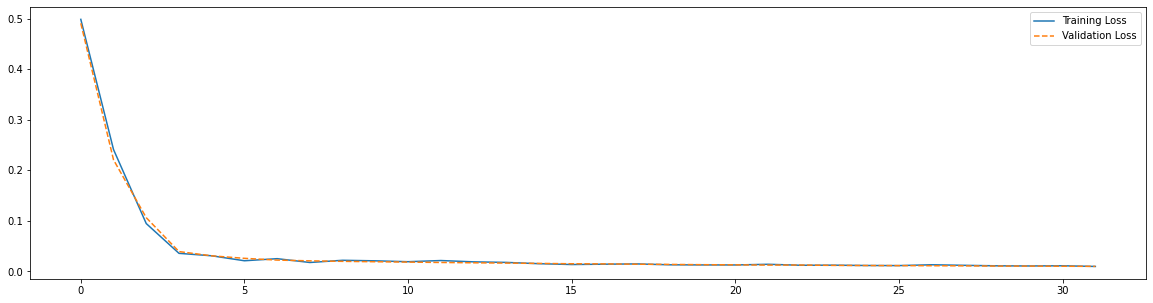

In [47]:
num_epochs = 2
input_dim = 1
hidden_size = 30
num_layers = 1
lr = 3e-4

Net = DenoiserLSTM(input_dim, hidden_size, 1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(Net.parameters(),lr=lr)

train_loader, test_loader = get_loader(50000)
loss_val, loss_train = train(100)

fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, '--',label='Validation Loss')
plt.legend()
plt.show()

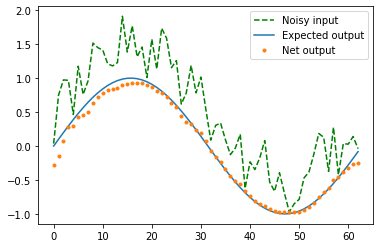

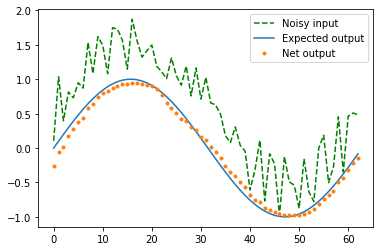

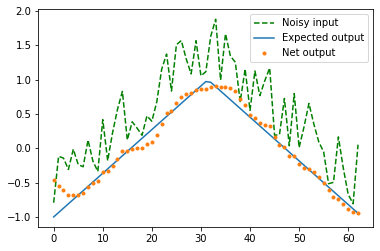

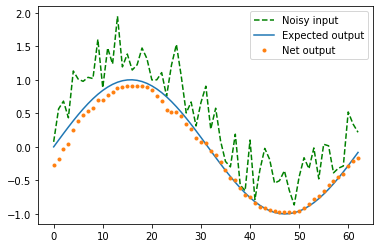

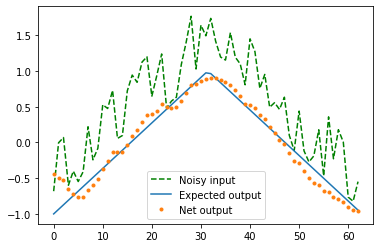

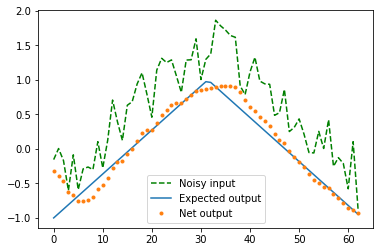

In [48]:
for idx, (noisy_data, main_data) in enumerate(test_loader):
    input2net = noisy_data.unsqueeze(2).float() 
    expected_out = main_data.unsqueeze(2).float()
    with torch.no_grad():
        output = Net(input2net)
    plt.plot(input2net[0,:,0].numpy(),'--g',label='Noisy input')
    plt.plot(expected_out[0,:,0].numpy(),label='Expected output')
    plt.plot(output[0,:,0].numpy(),'.',label='Net output')
    plt.legend()
    plt.show()
    if idx>4:
        break

### 2D Signal Denoising - circle

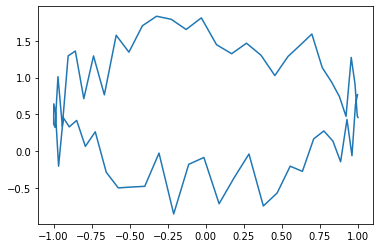

In [49]:
time_interval = np.arange(0,2*np.pi,0.1)
noise = np.random.rand(len(time_interval))
signal = np.sqrt(1-np.cos(time_interval)**2)+noise
plt.plot(np.cos(time_interval), np.sin(time_interval)+noise)

In [50]:
class WavesDataset(Dataset):
    def __init__(self, num_datas, variance):
        
        self.num_datas = num_datas
        self.noisy_datas = []
        self.real_datas = []
        time_interval = np.arange(0,2*np.pi,0.1)
        for i in range(self.num_datas):
            
            noise = np.random.rand(len(time_interval))
            data = np.sin(time_interval)+noise
            wave = np.sin(time_interval)
            self.noisy_datas.append(data)
            self.real_datas.append(wave)
        

    def __len__(self):
        return self.num_datas

    def __getitem__(self, index):
        noisy = self.noisy_datas[index]
        real = self.real_datas[index]

        return torch.tensor(noisy), torch.tensor(real)

0/5 - 0/1563 |  Loss train - val = 0.4739 - 0.4723
0/5 - 100/1563 |  Loss train - val = 0.1924 - 0.1891
0/5 - 200/1563 |  Loss train - val = 0.0172 - 0.0168
0/5 - 300/1563 |  Loss train - val = 0.0070 - 0.0069
0/5 - 400/1563 |  Loss train - val = 0.0038 - 0.0046
0/5 - 500/1563 |  Loss train - val = 0.0035 - 0.0036
0/5 - 600/1563 |  Loss train - val = 0.0032 - 0.0031
0/5 - 700/1563 |  Loss train - val = 0.0029 - 0.0028
0/5 - 800/1563 |  Loss train - val = 0.0025 - 0.0026
0/5 - 900/1563 |  Loss train - val = 0.0019 - 0.0024
0/5 - 1000/1563 |  Loss train - val = 0.0027 - 0.0023
0/5 - 1100/1563 |  Loss train - val = 0.0019 - 0.0021
0/5 - 1200/1563 |  Loss train - val = 0.0018 - 0.0020
0/5 - 1300/1563 |  Loss train - val = 0.0020 - 0.0019
0/5 - 1400/1563 |  Loss train - val = 0.0021 - 0.0018
0/5 - 1500/1563 |  Loss train - val = 0.0017 - 0.0017
1/5 - 0/1563 |  Loss train - val = 0.0017 - 0.0016
1/5 - 100/1563 |  Loss train - val = 0.0016 - 0.0016
1/5 - 200/1563 |  Loss train - val = 0.0013 

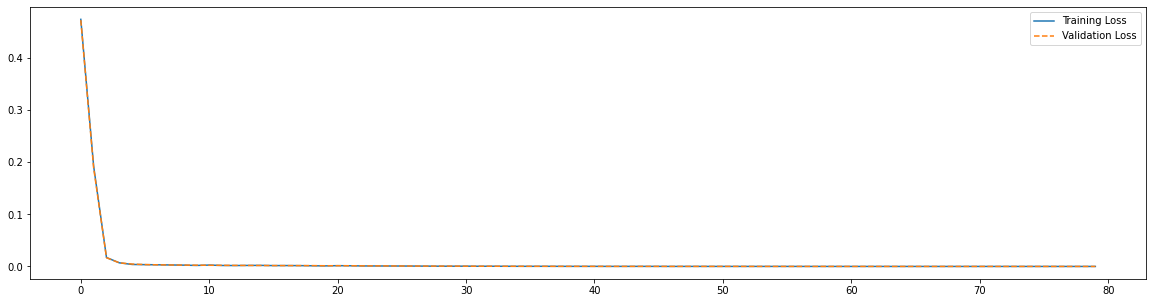

In [51]:
num_epochs = 5
input_dim = 1
hidden_size = 30
num_layers = 1
lr = 3e-4

Net = DenoiserLSTM(input_dim, hidden_size, 1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(Net.parameters(),lr=lr)

train_loader, test_loader = get_loader(50000)
loss_val, loss_train = train(100)

fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, '--',label='Validation Loss')
plt.legend()
plt.show()

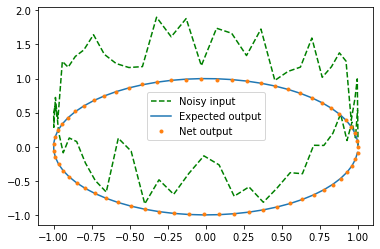

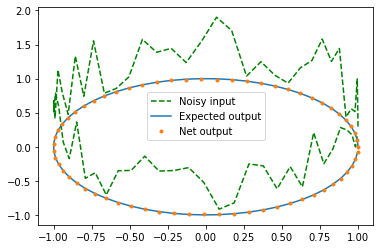

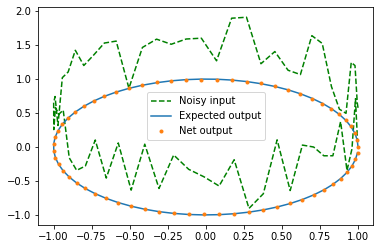

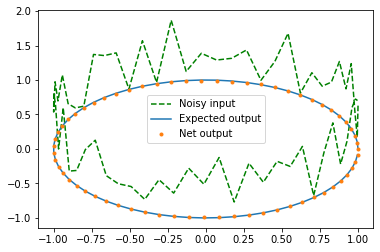

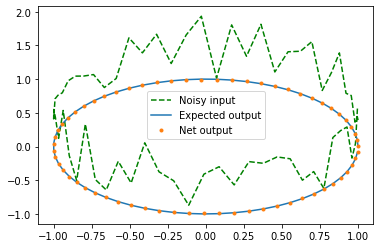

In [52]:
for idx, (noisy_data, main_data) in enumerate(test_loader):
    input2net = noisy_data.unsqueeze(2).float() 
    expected_out = main_data.unsqueeze(2).float()
    with torch.no_grad():
        output = Net(input2net)
    plt.plot(np.cos(time_interval), input2net[0,:,0].numpy(),'--g',label='Noisy input')
    plt.plot(np.cos(time_interval), expected_out[0,:,0].numpy(),label='Expected output')
    plt.plot(np.cos(time_interval), output[0,:,0].numpy(),'.',label='Net output')
    plt.legend()
    plt.show()
    if idx>3:
        break

### 2D Signal Denoising - Epitrochoid

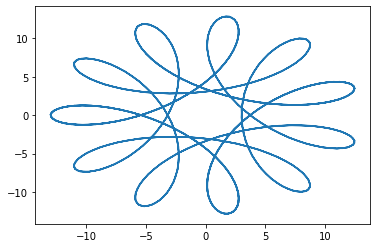

In [53]:
time_interval = np.arange(0,10*2*np.pi,0.1)
noise = np.random.rand(len(time_interval))
a=5
b=3
c=5
signal = (a+b)*np.cos(time_interval)-c*np.sin((a/b+1)*time_interval)
x = (a+b)*np.sin(time_interval)-c*np.cos((a/b+1)*time_interval)
plt.plot(x, signal)

In [54]:
class WavesDataset(Dataset):
    def __init__(self, num_datas, variance):
        
        self.num_datas = num_datas
        self.noisy_datas = []
        self.real_datas = []
        time_interval = np.arange(0,10*2*np.pi,0.1)
        a=5
        b=3
        c=5
        for i in range(self.num_datas):
            noise = np.random.normal(0,variance,len(time_interval))
            data = (a+b)*np.sin(time_interval)-c*np.sin((a/b+1)*time_interval)+noise
            wave = (a+b)*np.sin(time_interval)-c*np.sin((a/b+1)*time_interval)
            self.noisy_datas.append(data)
            self.real_datas.append(wave)
        

    def __len__(self):
        return self.num_datas

    def __getitem__(self, index):
        noisy = self.noisy_datas[index]
        real = self.real_datas[index]

        return torch.tensor(noisy), torch.tensor(real)

0/2 - 0/1563 |  Loss train - val = 42.4281 - 42.3674
0/2 - 100/1563 |  Loss train - val = 37.7790 - 37.7490
0/2 - 200/1563 |  Loss train - val = 35.8308 - 35.8208
0/2 - 300/1563 |  Loss train - val = 35.1292 - 35.1248
0/2 - 400/1563 |  Loss train - val = 34.8415 - 34.8395
0/2 - 500/1563 |  Loss train - val = 34.6967 - 34.6952
0/2 - 600/1563 |  Loss train - val = 34.6124 - 34.6116
0/2 - 700/1563 |  Loss train - val = 34.5605 - 34.5598
0/2 - 800/1563 |  Loss train - val = 34.5263 - 34.5257
0/2 - 900/1563 |  Loss train - val = 34.5021 - 34.5019
0/2 - 1000/1563 |  Loss train - val = 34.4857 - 34.4852
0/2 - 1100/1563 |  Loss train - val = 34.4733 - 34.4732
0/2 - 1200/1563 |  Loss train - val = 34.4640 - 34.4643
0/2 - 1300/1563 |  Loss train - val = 34.4575 - 34.4574
0/2 - 1400/1563 |  Loss train - val = 34.4523 - 34.4519
0/2 - 1500/1563 |  Loss train - val = 34.4474 - 34.4475
1/2 - 0/1563 |  Loss train - val = 34.4450 - 34.4452
1/2 - 100/1563 |  Loss train - val = 34.4420 - 34.4419
1/2 - 20

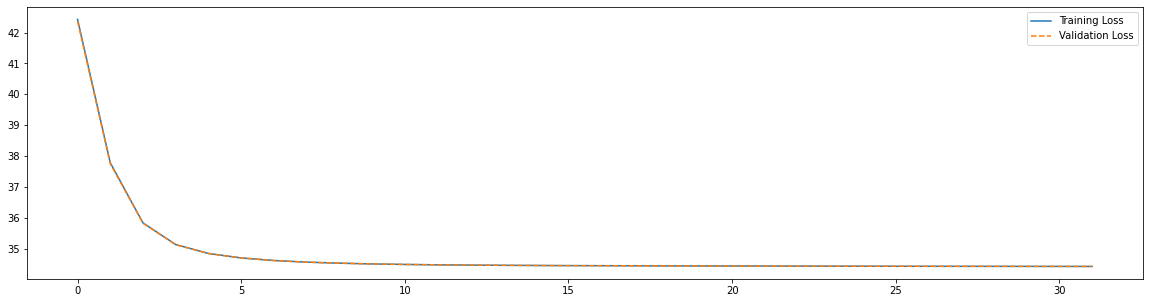

In [57]:
num_epochs = 2
input_dim = 1
hidden_size = 30
num_layers = 3
lr = 3e-4

Net = DenoiserLSTM(input_dim, hidden_size, 1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(Net.parameters(),lr=lr)

train_loader, test_loader = get_loader(50000,variance=0.2)
loss_val, loss_train = train(100)

fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, '--',label='Validation Loss')
plt.legend()
plt.show()

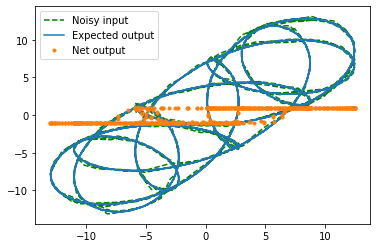

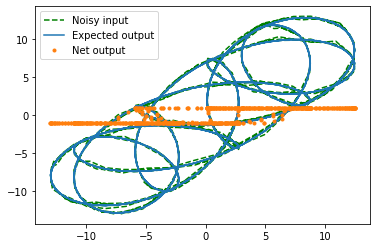

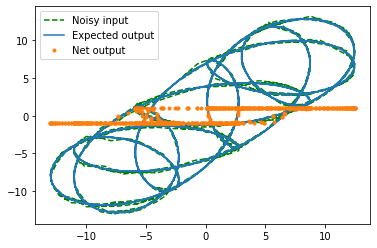

In [59]:
for idx, (noisy_data, main_data) in enumerate(test_loader):
    input2net = noisy_data.unsqueeze(2).float() 
    expected_out = main_data.unsqueeze(2).float()
    with torch.no_grad():
        output = Net(input2net)
    plt.plot(x, input2net[0,:,0].numpy(),'--g',label='Noisy input')
    plt.plot(x, expected_out[0,:,0].numpy(),label='Expected output')
    plt.plot(x, output[0,:,0].numpy(),'.',label='Net output')
    plt.legend()
    plt.show()
    if idx >1:        
        break

### 2D Signal Denoising - Nephroid

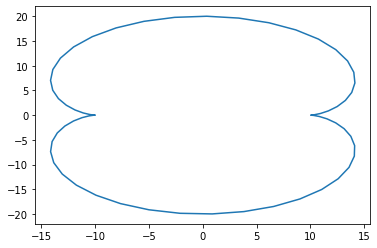

In [60]:
time_interval = np.arange(0,2*np.pi,0.1)
noise = np.random.rand(len(time_interval))
a=5
signal = a*(np.sin(3*time_interval)-3*np.sin(time_interval))
x = a*(np.cos(3*time_interval)-3*np.cos(time_interval))
plt.plot(x, signal)

In [61]:
class WavesDataset(Dataset):
    def __init__(self, num_datas, variance):
        
        self.num_datas = num_datas
        self.noisy_datas = []
        self.real_datas = []
        time_interval = np.arange(0,2*np.pi,0.1)
        a=5
        b=3
        c=5
        for i in range(self.num_datas):
            noise = np.random.normal(0,variance,len(time_interval))
            data = a*(np.sin(3*time_interval)-3*np.sin(time_interval))+noise
            wave = a*(np.sin(3*time_interval)-3*np.sin(time_interval))
            self.noisy_datas.append(data)
            self.real_datas.append(wave)
        

    def __len__(self):
        return self.num_datas

    def __getitem__(self, index):
        noisy = self.noisy_datas[index]
        real = self.real_datas[index]

        return torch.tensor(noisy), torch.tensor(real)

0/2 - 0/1563 |  Loss train - val = 128.4758 - 121.1699
0/2 - 100/1563 |  Loss train - val = 108.6177 - 108.6176
0/2 - 200/1563 |  Loss train - val = 108.6158 - 108.6162
0/2 - 300/1563 |  Loss train - val = 108.5835 - 108.5833
0/2 - 400/1563 |  Loss train - val = 108.5826 - 108.5827
0/2 - 500/1563 |  Loss train - val = 108.5824 - 108.5823
0/2 - 600/1563 |  Loss train - val = 108.5820 - 108.5819
0/2 - 700/1563 |  Loss train - val = 108.5819 - 108.5817
0/2 - 800/1563 |  Loss train - val = 108.5814 - 108.5816
0/2 - 900/1563 |  Loss train - val = 108.5813 - 108.5814
0/2 - 1000/1563 |  Loss train - val = 108.5812 - 108.5812
0/2 - 1100/1563 |  Loss train - val = 108.5810 - 108.5811
0/2 - 1200/1563 |  Loss train - val = 108.5810 - 108.5810
0/2 - 1300/1563 |  Loss train - val = 108.5809 - 108.5809
0/2 - 1400/1563 |  Loss train - val = 108.5809 - 108.5808
0/2 - 1500/1563 |  Loss train - val = 108.5817 - 108.5822
1/2 - 0/1563 |  Loss train - val = 108.5809 - 108.5808
1/2 - 100/1563 |  Loss train 

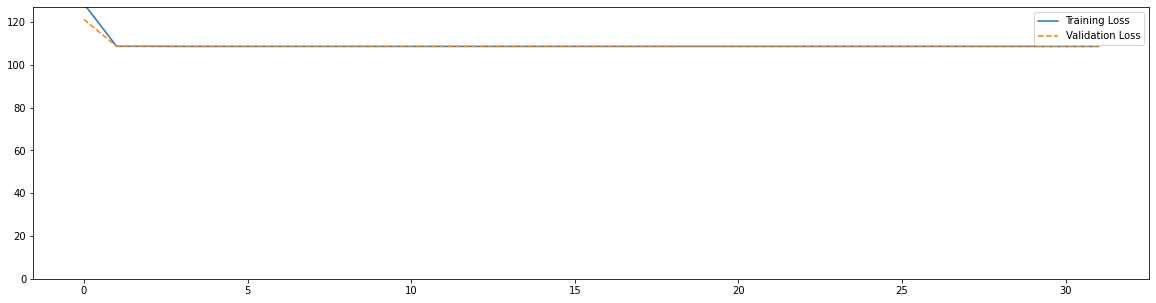

In [63]:
num_epochs = 2
input_dim = 1
hidden_size = 60
num_layers = 1
lr = 1e-2

Net = DenoiserLSTM(input_dim, hidden_size, 1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(Net.parameters(),lr=lr)

train_loader, test_loader = get_loader(50000,variance=0.2)
loss_val, loss_train = train(100)

fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, '--',label='Validation Loss')
plt.legend()
plt.ylim([0,127])
plt.show()

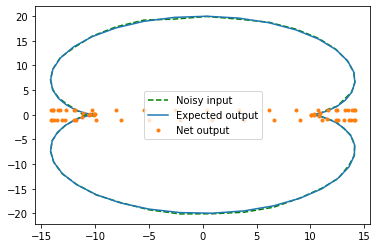

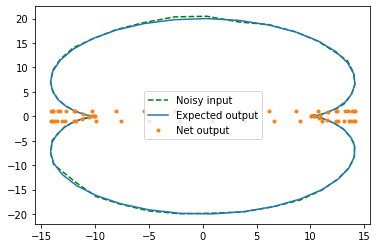

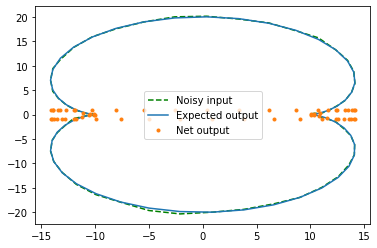

In [64]:
for idx, (noisy_data, main_data) in enumerate(test_loader):
    input2net = noisy_data.unsqueeze(2).float() 
    expected_out = main_data.unsqueeze(2).float()
    with torch.no_grad():
        output = Net(input2net)
    plt.plot(x, input2net[0,:,0].numpy(),'--g',label='Noisy input')
    plt.plot(x, expected_out[0,:,0].numpy(),label='Expected output')
    plt.plot(x, output[0,:,0].numpy(),'.',label='Net output')
    plt.legend()
    plt.show()
    if idx>1:
        break

### Signal Denoising - Music

In [65]:
from scipy.io import wavfile
fs, data = wavfile.read('message.wav')

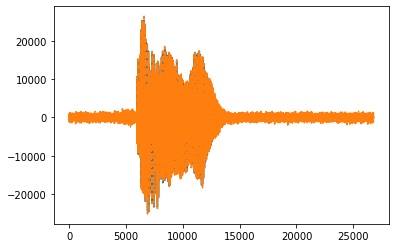

In [66]:
time_interval = np.arange(0,len(data),1)
noise = np.random.normal(0,500,len(data))
plt.plot(data)
plt.plot(data+noise,'--')

In [67]:
type(data+noise)

numpy.ndarray

In [68]:
class WavesDataset(Dataset):
    def __init__(self, num_datas, variance):
        
        self.num_datas = num_datas
        self.noisy_datas = []
        self.real_datas = []
        _,wave = wavfile.read('message.wav')
        time_interval = np.arange(0,len(wave),1)

        for i in range(self.num_datas):
            noise = np.random.normal(0,variance,len(time_interval))
            data = wave+noise
            self.noisy_datas.append(data)
            self.real_datas.append(wave)

        

    def __len__(self):
        return self.num_datas

    def __getitem__(self, index):
        noisy = torch.from_numpy(self.noisy_datas[index])
        real =  torch.from_numpy(self.real_datas[index])

        return noisy, real

In [ ]:
num_epochs = 5
input_dim = 1
hidden_size = 6000
num_layers = 1
lr = 1e-2

Net = DenoiserLSTM(input_dim, hidden_size, 1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(Net.parameters(),lr=lr)

train_loader, test_loader = get_loader(50,variance=500)
loss_val, loss_train = train(2)

fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, '--',label='Validation Loss')
plt.legend()
plt.show()

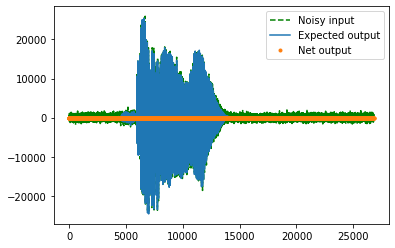

In [413]:
for idx, (noisy_data, main_data) in enumerate(test_loader):
    input2net = noisy_data.unsqueeze(2).float() 
    expected_out = main_data.unsqueeze(2).float()
    with torch.no_grad():
        output = Net(input2net)
    plt.plot(input2net[0,:,0].numpy(),'--g',label='Noisy input')
    plt.plot(expected_out[0,:,0].numpy(),label='Expected output')
    plt.plot(output[0,:,0].numpy(),'.',label='Net output')
    plt.legend()
    plt.show()
    break

### Signal Denoising - Image

In [11]:
from PIL import Image
img = Image.open("city-sample.jpeg").convert('L')
img = img.resize((96,54))

In [12]:
np.shape(img)

(54, 96)

In [13]:
noise = np.random.normal(0,50,96*54)
img = np.reshape(img,-1)
img+noise

array([ 41.23813819,  62.40887369,  14.73700386, ..., -74.18399062,
        85.16044132,  48.7411889 ])

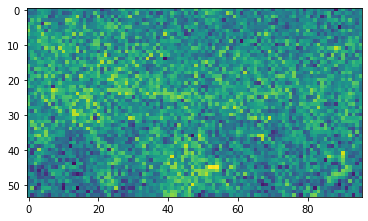

In [31]:
plt.imshow(np.reshape(img+noise,[54,96]))

In [15]:
class WavesDataset(Dataset):
    def __init__(self, num_datas, variance):
        
        self.num_datas = num_datas
        self.noisy_datas = []
        self.real_datas = []
        wave = Image.open("city-sample.jpeg").convert('L')
        wave = wave.resize((96,54))
        wave = np.reshape(wave, -1)

        for i in range(self.num_datas):
            noise = np.random.normal(0,variance,96*54)
            data = wave+noise
            self.noisy_datas.append(data)
            self.real_datas.append(wave)

        

    def __len__(self):
        return self.num_datas

    def __getitem__(self, index):
        noisy = torch.from_numpy(self.noisy_datas[index])
        real =  torch.from_numpy(self.real_datas[index])

        return noisy, real

In [28]:
num_epochs = 10
input_dim = 1
hidden_size = 256
num_layers = 1
lr = 3e-4

Net = DenoiserLSTM(input_dim, hidden_size, 1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(Net.parameters(),lr=lr)

train_loader, test_loader = get_loader(1000,variance=50,shuffle=False)

0/10 - 0/32 |  Loss train - val = 8631.7129 - 8614.5005
0/10 - 10/32 |  Loss train - val = 8497.0986 - 8488.9077
0/10 - 20/32 |  Loss train - val = 8451.1699 - 8449.3433
0/10 - 30/32 |  Loss train - val = 8440.9443 - 8440.4995
1/10 - 0/32 |  Loss train - val = 8440.1309 - 8439.8032
1/10 - 10/32 |  Loss train - val = 8438.1543 - 8438.0637
1/10 - 20/32 |  Loss train - val = 8437.4775 - 8437.4263
1/10 - 30/32 |  Loss train - val = 8437.2109 - 8437.1880
2/10 - 0/32 |  Loss train - val = 8437.1699 - 8437.1553
2/10 - 10/32 |  Loss train - val = 8437.0137 - 8437.0103
2/10 - 20/32 |  Loss train - val = 8436.9355 - 8436.9331
2/10 - 30/32 |  Loss train - val = 8436.8955 - 8436.8870
3/10 - 0/32 |  Loss train - val = 8436.8838 - 8436.8801
3/10 - 10/32 |  Loss train - val = 8436.8506 - 8436.8530
3/10 - 20/32 |  Loss train - val = 8436.8359 - 8436.8367
3/10 - 30/32 |  Loss train - val = 8436.8291 - 8436.8237
4/10 - 0/32 |  Loss train - val = 8436.8223 - 8436.8210
4/10 - 10/32 |  Loss train - val = 8

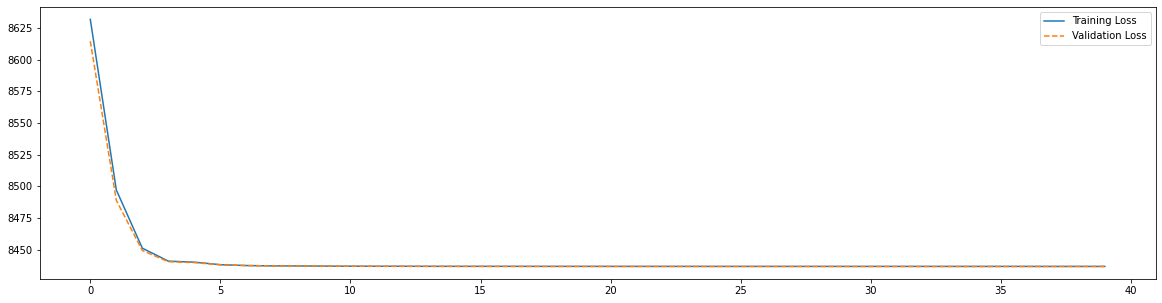

In [29]:
loss_val, loss_train = train(10)

fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, '--',label='Validation Loss')
plt.legend()
plt.show()